# noise hic experiment
simulating noise onto dlbcl data and applying denoising methods

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import seaborn as sns
from sklearn.decomposition import PCA
import math
from skimage.metrics import structural_similarity as ssim
import cv2

## custom imports

In [2]:
import sys
sys.path.append(os.path.abspath('..'))

from lib.chess_functions import clipped_zoom, highlight_features, clip_rotate
from lib.pca import collect_windows, reconstruct_from_windows, apply_pca
from lib.autoencoder import build_autoencoder, apply_autoencoder
from lib.mf import matrix_factorization
from lib.svt import svt
from lib.noise import add_noise_and_blur
from lib.stats import root_mean_squared_error, structural_similarity, explained_variance_score
from lib.load_data import load_hic_data     

## load hic data

In [3]:
patient_region_sub, control_region_sub = load_hic_data(script_dir=os.path.abspath('..'))
print("loaded hic")

loaded hic


## add noise to 0.005 as example

In [4]:
# Set var size
noise_level = 0.005
blur_strength = 2

# raw matrices
rot_patient = clip_rotate(patient_region_sub)

rot_control = clip_rotate(control_region_sub)

# Apply PCA
pca_matrix1 = add_noise_and_blur(patient_region_sub, noise_level, blur_strength)
rot_pca1 = clip_rotate(pca_matrix1) 

pca_matrix2 = add_noise_and_blur(control_region_sub, noise_level, blur_strength)
rot_pca2 = clip_rotate(pca_matrix2)

# Compute PCA difference matrix (patient - control)
diff_pca1 = pca_matrix1 - pca_matrix2 # pca_matrix1 - pca_matrix2
rot_diff_pca1 = clip_rotate(diff_pca1)

# subtract inverse (control - patient)
diff_pca2 = pca_matrix2 - pca_matrix1
rot_diff_pca2 = clip_rotate(diff_pca2)

# log2(obs/exp) calc
safe_div = pca_matrix1 / pca_matrix2
safe_div[safe_div == 0] = np.nan
safe_div = abs(safe_div)
log_pca1 =  np.log2(safe_div) # pca_matrix1 / pca_matrix2 of pca applied
rot_log_pca1 = clip_rotate(log_pca1)

log_pca2 =  np.log2(patient_region_sub / control_region_sub) # pca_matrix1 / pca_matrix2 of normal matrices
rot_log_pca2 = clip_rotate(log_pca2)

## generate plots

Plot saved to out/005_noise_hic.png


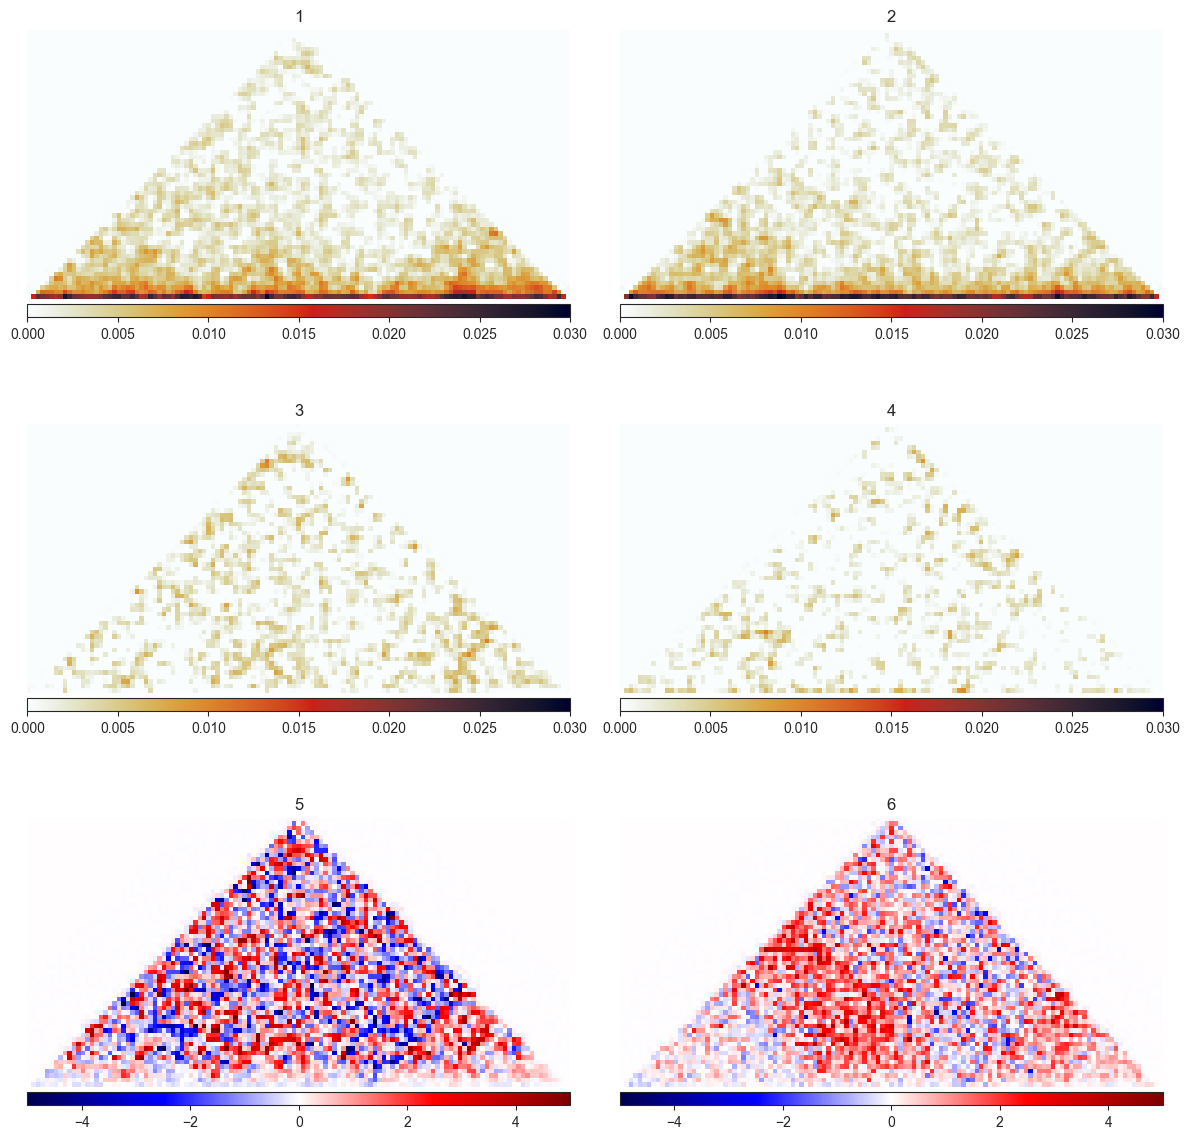

In [5]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

middle = int(np.shape(rot_control)[1]/ 2.)

# Second row: PCA transformed matrices
m1 = axes[0][0].imshow(rot_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 0].set_title("1")

m2 = axes[0][1].imshow(rot_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[0, 1].set_title("2")

# Third row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(rot_diff_pca1[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 0].set_title("3")

m4 = axes[1][1].imshow(rot_diff_pca2[:middle, :], vmin=0, vmax=0.03, cmap='germany')
axes[1, 1].set_title("4")

# Fourth Row:
# apply log2(obs/exp) from pca modified matrices and raw matrices
m5 = axes[2][0].imshow(rot_log_pca1[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 0].set_title("5")

m6 = axes[2][1].imshow(rot_log_pca2[:middle, :], vmin=-5, vmax=5, cmap='seismic')
axes[2, 1].set_title("6")

color_bars = [m1, m2, m3, m4, m5, m6]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "005_noise_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")

## simulate noise and denoise matrices

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import structural_similarity as ssim

import seaborn as sns
from sklearn.decomposition import PCA
import math

from sklearn.decomposition import TruncatedSVD

from numpy.linalg import svd

# keep blur the same, increment noise_level for n different levels

# add them to patient region

noise_levels = [0, 0.005, 0.01, 0.015, 0.03, 0.035, 0.04, 0.05, 0.08, 0.09, 0.1] 

noisy_matrices = []

# add noise to matrices
i = 0
for n in noise_levels:
    noisy_matrices.append(add_noise_and_blur(patient_region_sub, n, blur_strength))
    i += 1
    
# compute denoise on each noisy matrix
pca_denoised = []
auto_denoised = []
mf_denoised = []
svt_denoised = []

for matrix in noisy_matrices:
    pca_denoised.append(apply_pca(matrix))
    auto_denoised.append(apply_autoencoder(matrix))
    mf_denoised.append(matrix_factorization(matrix))
    svt_denoised.append(svt(matrix))

original = patient_region_sub
pca_stat = []
auto_stat = []
mf_stat = []
svt_stat = []

for k in range(0, len(noise_levels)):
    noise_matrix = noisy_matrices[k]
    pca_stat.append(structural_similarity(noise_matrix, pca_denoised[k]))
    auto_stat.append(structural_similarity(noise_matrix, auto_denoised[k]))
    mf_stat.append(structural_similarity(noise_matrix, mf_denoised[k]))
    svt_stat.append(structural_similarity(noise_matrix, svt_denoised[k]))

Epoch 1/50


/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0546  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0396 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0371 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0355 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0336 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0962  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0782 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0679 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0619 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0571 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0532 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0463 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0347 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0328
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0310 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0298 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1630  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1243 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1031 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0884 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0769 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0670 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0599 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0478 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0389 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0353 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0334 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0301 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1918  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1506 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1255 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1086 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0944 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0819 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0722 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0626 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0566 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0507 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0391 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0374 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0361 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3568  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2698 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2198 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1891 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1617 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1373 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1193 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1022 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0897 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0775 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0674 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0608 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0553 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0506 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0480 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3506  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2615 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2133 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1779 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1505 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1271 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1074 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0890 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0760 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0668 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0594 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0548 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0530 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0493 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0480 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3446  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2673 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2061 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1631 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1321 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1103 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0921 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0774 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0669 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0590 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0547 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0507 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0493 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0487 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0481 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3543  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2686 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2224 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1867 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1576 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1363 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1155 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1020 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0878 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0756 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0688 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0624 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0583 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0557 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0522 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3925  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3058 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2505 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2175 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1903 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1647 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1440 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1225 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1042 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0894 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0777 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0681 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0620 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0565 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3740  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2940 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2464 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2113 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1776 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1506 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1231 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1044 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0893 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0763 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0673 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0615 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0536 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0514 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4092  
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3269 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2724 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2282 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1904 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1607 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1350 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1120 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0936 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0804 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0692 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0627 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0577 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0539 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0509 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/

## plot noise level plot

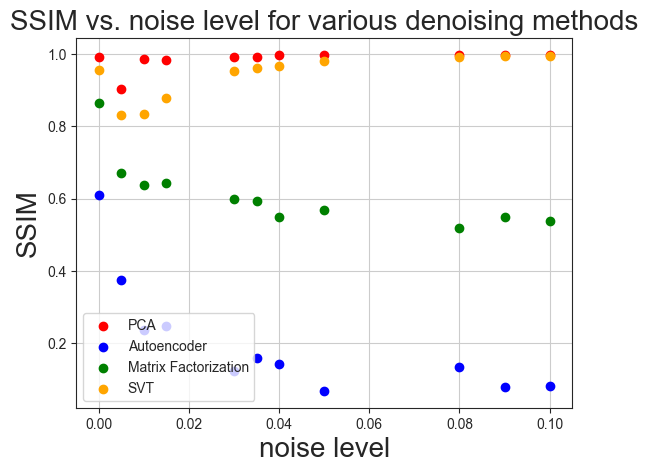

In [8]:
# Create scatter plot
plt.scatter(noise_levels, pca_stat, color='red', label='PCA')
plt.scatter(noise_levels, auto_stat, color='blue', label='Autoencoder')
plt.scatter(noise_levels, mf_stat, color='green', label='Matrix Factorization')
plt.scatter(noise_levels, svt_stat, color='orange', label='SVT')

# Labels and legend
plt.xlabel('noise level', fontsize=20)
plt.ylabel('SSIM', fontsize=20)
plt.title('SSIM vs. noise level for various denoising methods', fontsize=20)
plt.legend()
plt.grid(True)

save_path = os.path.join("out", "all_noise.png")
plt.savefig(save_path, dpi=300)  # High resolution and tight layout

# Show plot
plt.show()